# PRUEBA JOSÉ FERNANDO ZEA CASTRO

# CONTENIDO

* Análisis exploratorio de datos
* Comparación de modelos
* Pronósticos de modelos y descomposición de series de tiempo
* Conclusiones

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Módulo  para realizar visualizaciones
from plotnine import * # módulo para realizar visualizaciones (ggplot)
from fbprophet import Prophet # Series de tiempo con modelos aditivos (y multiplicativos)
from fbprophet.plot import plot_plotly, plot_components_plotly
import sklearn # Usamos las métricas de este modullo (submódulo metrics)
import pmdarima
from pmdarima.arima import auto_arima


In [71]:
# Lectura de datos
os.chdir(r'C:\Users\Stats\Documents\Prueba Técnica MinTic')
df = pd.read_csv('newyearresolution.csv',  sep =",")
df.tail(5)  

,Month,diet: (Worldwide),gym: (Worldwide),finance: (Worldwide)
193,2020-02,48,56,61
194,2020-03,34,51,77
195,2020-04,37,37,65
196,2020-05,44,39,62
197,2020-06,44,40,77


In [3]:
# Cambiar los nombres para mayor facilidad de accecso a los "features":
df.columns = ['month', 'diet', 'gym', 'finance']
# Convertir de caracter a fecha:
df['month']= pd.to_datetime(df['month'])
df.head(5)

,month,diet,gym,finance
0,2004-01-01,100,31,48
1,2004-02-01,77,27,49
2,2004-03-01,71,25,47
3,2004-04-01,71,23,48
4,2004-05-01,73,23,44


# ANÁLISIS EXPLORATORIO DE DATOS

C:\ProgramData\Anaconda3\lib\site-packages\plotnine\scales\scale.py:103: PlotnineWarning: scale_x_datetime could not recognise parameter `datebreaks`


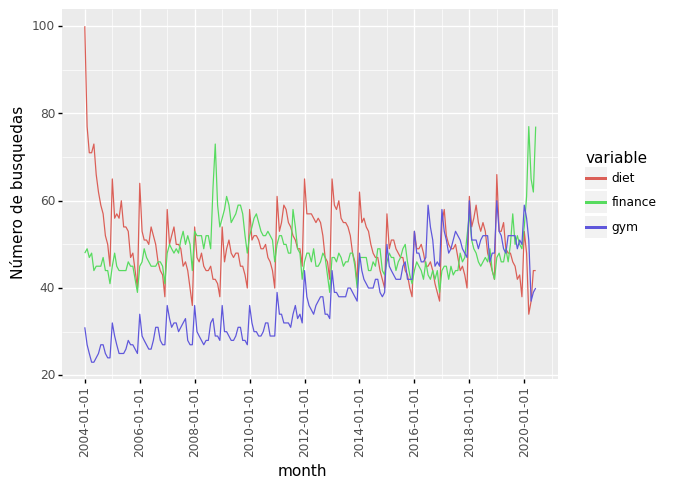

<ggplot: (94036043969)>

In [4]:
# Reestructurar información a una base larga para llevar a cabo una visualización de las series temporales:
df_long = pd.melt(df, id_vars=['month'], value_vars=['diet', 'gym', 'finance'])
df_long.head(5)

# Serie de tiempo
(ggplot(df_long)
 + geom_line(aes(x = 'month', y = 'value', color = 'variable'))
 + labs(y='Número de busquedas')
 + scale_x_datetime(datebreaks='3 months')  
 + theme(axis_text_x=element_text(angle=90))
)


Se observan tres series con comportamientos muy diferentes en sus tendencias, gym presentan una tendencia creciente, la serie diet y también gym con una fuerte estacionalidad (especialmente con un pico en enero) y la serie financiera sin una estacionalidad clara a simple viste y con cambios muy fuertes en algunos años.

In [5]:
corrMatrix = df.corr()
print (corrMatrix)

             diet       gym   finance
diet     1.000000 -0.070994 -0.140714
gym     -0.070994  1.000000 -0.087604
finance -0.140714 -0.087604  1.000000


Las series presentan muy baja correlación, con lo cual se descarta la utilidad de hacer uso del análisis de series de tiempo cointegradas para que entre ellas se retroalimenten para elaborar pronsoticos más precisos.
Se abordarán dos metodologías de análisis y pronostico de series temporales, los modelos SARIMA y un modelo de series temporales aditivo basado en la descomposición en tendencia y componente estacional.

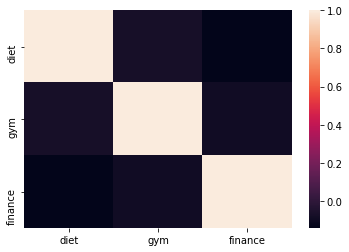

In [6]:
df_corr= df.corr()
sns.heatmap(df_corr)
plt.show()


# COMPARACIÓN DE MODELOS DE SERIES TEMPORALES

A continuación se ilustra la estrategia para desarrollar un modelo predictivo. En primer lugar para tener un criterio objetivo de que tan efectivo es el modelo propuesto se entrena el modelo removiendo las 12 últimas observaciones y se analizan algunas métricas por por ejemplo el error cuadrátivo medio, el arror absoluto medio.:

$$
MAE = \frac{\sum_{i=1}^{n}|y_i-\hat{y_i}|}{n}
$$

Otra métrica relevante en esta clase de estudios es la error cuadrático medio:


:
$$
RMSE = \sqrt{\frac{\sum_{i=1}^{n}(y_i-\hat{y_i})^2}{n}}
$$


A continuación se ilustra la estrategia detallada para evaluar dos modelos: un modelo basado en modelos aditivos que ajuste componentes de tendencia y estacionalidad basado en el módulo prophet desarrollado por facebook y un modelo SARIMA el cual se enmarca en los modelos más tradicionales de series de tiempo. Ajustaremos los dos modelos dejando el último año por fuera de muestra y compararemos el error absoluto medio (MAE) y la raiz cuadrada del error cuadrático medio (RMSE). Para ilustrar la estrategia de ajsute y evaluación utilizaremos la serie de busqueda de la palabra dieta para luego proceder a replicar los dos modelos en las otras dos variables:


## Comparación de modelos para la serie temporal "diet"

Cargamos la serie de tiempo de dieta y lo enmarcamos en una estructura de datos de pandas:

In [7]:
df_diet = df[["month", "diet"]]
df_diet.columns=['ds', 'y']
df_diet.tail()

,ds,y
193,2020-02-01,48
194,2020-03-01,34
195,2020-04-01,37
196,2020-05-01,44
197,2020-06-01,44


COn el proposito de evaluar el modelo consideraremos como muestra de entrenamientos los datos exlcuyendo los últimos 12 meses de información disponible (desde enero de 2004 hasta hasta Junio de 2019). Como muestra de prueba consideraremos la información dispoible desde Julio de 2019 hasta Junio de 2020

In [8]:
train_diet = df_diet.drop(df.index[-12:])
train_diet

,ds,y
0,2004-01-01,100
1,2004-02-01,77
2,2004-03-01,71
3,2004-04-01,71
4,2004-05-01,73
...,...,...
181,2019-02-01,53
182,2019-03-01,53
183,2019-04-01,55
184,2019-05-01,49


In [9]:
test_diet = df_diet.iloc[-12:]
test_diet

,ds,y
186,2019-07-01,48
187,2019-08-01,46
188,2019-09-01,45
189,2019-10-01,42
190,2019-11-01,43
191,2019-12-01,38
192,2020-01-01,53
193,2020-02-01,48
194,2020-03-01,34
195,2020-04-01,37


In [ ]:
Entrenaremos el modelo con la muestra de entrenamiento y previsualicemos los pronosticos desde Julio de 2019 hasta Junio de 2020:

In [11]:
modelProphetTrain_diet = Prophet()
modelProphetTrain_diet.fit(train_diet)
forecastProphetTest_diet = modelProphetTrain_diet.predict(test_diet)
forecastProphetTest_diet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-07-01,51.763066,49.920545,56.294905,51.763066,51.763066,1.255159,1.255159,1.255159,1.255159,1.255159,1.255159,0.0,0.0,0.0,53.018225
1,2019-08-01,51.896826,47.892810,54.362347,51.886160,51.906076,-0.735163,-0.735163,-0.735163,-0.735163,-0.735163,-0.735163,0.0,0.0,0.0,51.161662
2,2019-09-01,52.030586,45.992044,52.256654,51.982786,52.082309,-2.926494,-2.926494,-2.926494,-2.926494,-2.926494,-2.926494,0.0,0.0,0.0,49.104092
3,2019-10-01,52.160031,44.294721,50.847624,52.052790,52.267896,-4.480290,-4.480290,-4.480290,-4.480290,-4.480290,-4.480290,0.0,0.0,0.0,47.679741
4,2019-11-01,52.293791,42.205377,48.720286,52.121898,52.487940,-6.952396,-6.952396,-6.952396,-6.952396,-6.952396,-6.952396,0.0,0.0,0.0,45.341395
5,2019-12-01,52.423236,38.910918,45.453901,52.170843,52.711461,-10.283306,-10.283306,-10.283306,-10.283306,-10.283306,-10.283306,0.0,0.0,0.0,42.139930
6,2020-01-01,52.556996,62.239599,68.545854,52.209498,52.941466,12.862945,12.862945,12.862945,12.862945,12.862945,12.862945,0.0,0.0,0.0,65.419941
7,2020-02-01,52.690756,51.712776,58.316966,52.237636,53.175148,2.113588,2.113588,2.113588,2.113588,2.113588,2.113588,0.0,0.0,0.0,54.804344
8,2020-03-01,52.815886,52.550423,59.293820,52.256708,53.410281,3.365406,3.365406,3.365406,3.365406,3.365406,3.365406,0.0,0.0,0.0,56.181293
9,2020-04-01,52.949646,53.123779,59.587598,52.250015,53.652780,3.483551,3.483551,3.483551,3.483551,3.483551,3.483551,0.0,0.0,0.0,56.433198


El pronostico con este modelo se observa a continuación sobre la base test se observa a continuación:

In [13]:
y_true_Prophet_diet = test_diet['y'].values
y_pred_Prophet_diet = forecastProphetTest_diet['yhat'].values
df_predTestProphet_diet = pd.DataFrame({'date':test_diet.ds, 'y':y_true_Prophet_diet, 
                'y_hat':y_pred_Prophet_diet})

df_predTestProphet_diet

,date,y,y_hat
186,2019-07-01,48,53.018225
187,2019-08-01,46,51.161662
188,2019-09-01,45,49.104092
189,2019-10-01,42,47.679741
190,2019-11-01,43,45.341395
191,2019-12-01,38,42.139930
192,2020-01-01,53,65.419941
193,2020-02-01,48,54.804344
194,2020-03-01,34,56.181293
195,2020-04-01,37,56.433198


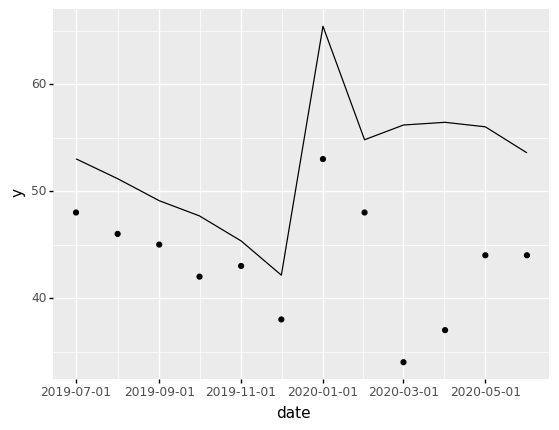

<ggplot: (94036056203)>

In [14]:
(ggplot(df_predTestProphet_diet, aes(x = 'date', y = 'y'))
 + geom_point() 
 + geom_line(aes(x = 'date', y = 'y_hat')))

Las dos métricas para el modelo aditivo son:

In [21]:
# Calcular métricas sobre la muestra de entrenamiento
maePhrophet_diet = sklearn.metrics.mean_absolute_error(y_true_Prophet_diet, y_pred_Prophet_diet)
rmseProphet_diet = math.sqrt(sklearn.metrics.mean_squared_error(y_true_Prophet_diet, y_pred_Prophet_diet))
print('MAE: %.3f' % maePhrophet_diet)
print('RMSE: %.3f' % rmseProphet_diet)

MAE: 9.073
RMSE: 10.916


A continuación realizamos el entrenamiento conn el modelo SARIMA:

In [22]:
# Datos de entrenamiento para ajustar el modelo SARIMA 
y_train_diet = train_diet.y.to_numpy()


In [23]:
# Ajuste de modelo Sarima (busqueda automática de parámetros)
modelSArimaTrain_diet = auto_arima(y_train_diet, error_action='ignore', seasonal=True, m=12)


El modelo se aplica sobre la base de prueba:

In [25]:
y_predTestArima_diet = modelSArimaTrain_diet.predict(n_periods=test_diet.shape[0])
df_predTestArima_diet = pd.DataFrame({'date':test_diet.ds, 'y':test_diet.y, 'y_hat':modelSArimaTrain_diet.predict(n_periods=test_diet.shape[0])
})
df_predTestArima_diet

,date,y,y_hat
186,2019-07-01,48,48.638396
187,2019-08-01,46,47.371262
188,2019-09-01,45,44.179380
189,2019-10-01,42,42.411252
190,2019-11-01,43,40.527394
191,2019-12-01,38,37.912968
192,2020-01-01,53,58.638726
193,2020-02-01,48,50.186964
194,2020-03-01,34,50.114441
195,2020-04-01,37,51.333763


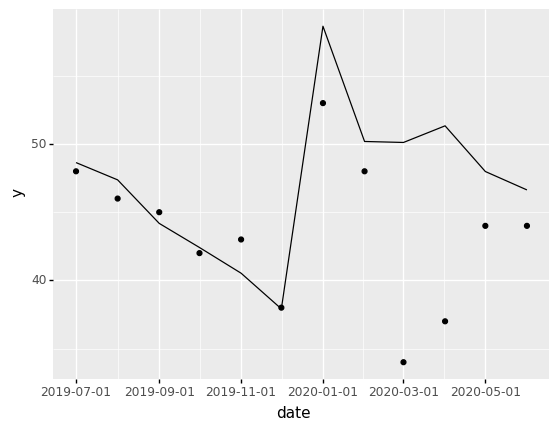

<ggplot: (94038964405)>

In [26]:
(ggplot(df_predTestArima_diet, aes(x = 'date', y = 'y'))
 + geom_point() 
 + geom_line(aes(x = 'date', y = 'y_hat')))

In [28]:
# calculate MAE between expected and predicted values for december
y_true_Arima_diet = df_predTestArima_diet.y
y_pred_Arima_diet = df_predTestArima_diet.y_hat
mae_Arima_diet = sklearn.metrics.mean_absolute_error(y_true_Arima_diet, y_pred_Arima_diet)
rmse_Arima_diet = math.sqrt(sklearn.metrics.mean_squared_error(y_true_Arima_diet, y_pred_Arima_diet))
print('MAE: %.3f' % mae_Arima_diet)
print('RMSE: %.3f' % rmse_Arima_diet)

MAE: 4.224
RMSE: 6.669


## Comparación de modelos para la serie de finanzas

A continuación evaluaremos cual de los dos modelos es mejor para pronosticar para la serie temporal "finance"

In [47]:
# Datos de entrenamiento y de prueba para la serie de finanzas
df_finance = df[["month", "finance"]]
df_finance.columns=['ds', 'y']

train_finance = df_finance.drop(df.index[-12:])
test_finance = df_finance.iloc[-12:]

# Datos de entrenamiento para ajustar el modelo SARIMA
y_train_finance = train_finance.y.to_numpy()
df_finance

,ds,y
0,2004-01-01,48
1,2004-02-01,49
2,2004-03-01,47
3,2004-04-01,48
4,2004-05-01,44
...,...,...
193,2020-02-01,61
194,2020-03-01,77
195,2020-04-01,65
196,2020-05-01,62


In [37]:
# Modelo aditivio para la serie de finanzas
modelProphetTrain_finance = Prophet()
modelProphetTrain_finance.fit(train_finance)
forecastProphetTest_finance = modelProphetTrain_finance.predict(test_finance)

# Calcular métricas sobre la muestra de entrenamiento para el modelo aditivo
y_true_Prophet_finance = test_finance['y'].values
y_pred_Prophet_finance = forecastProphetTest_finance['yhat'].values
maePhrophet_finance = sklearn.metrics.mean_absolute_error(y_true_Prophet_finance, y_pred_Prophet_finance)
rmseProphet_finance = math.sqrt(sklearn.metrics.mean_squared_error(y_true_Prophet_finance, y_pred_Prophet_finance))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
# Estimación del modelo Sarima para la serie de finanzas

# Ajuste de modelo SARIMA (busqueda automática de parámetros)
modelSArimaTrain_finance = auto_arima(y_train_finance, error_action='ignore', seasonal=True, m=12)
df_predTestArima_finance = pd.DataFrame({'date':test_finance.ds, 'y':test_finance.y, 'y_hat':modelSArimaTrain_finance.predict(n_periods=test_finance.shape[0])})

# Calcular métricas sobre la muestra de entrenamiento para el modelo SARIMA

y_true_Arima_finance = df_predTestArima_finance.y
y_pred_Arima_finance = df_predTestArima_finance.y_hat
mae_Arima_finance = sklearn.metrics.mean_absolute_error(y_true_Arima_finance, y_pred_Arima_finance)
rmse_Arima_finance = math.sqrt(sklearn.metrics.mean_squared_error(y_true_Arima_finance, y_pred_Arima_finance))

In [ ]:
Se comparan las métricas de los dos modelos para la serie de finanzas

In [46]:
print('MAE Modelo Aditivo: %.3f' % maePhrophet_finance)
print('RMSE Modelo Aditivo: %.3f' % rmseProphet_finance)

print('MAE: %.3f' % mae_Arima_finance)
print('RMSE: %.3f' % rmse_Arima_finance)

MAE Modelo Aditivo: 11.786
RMSE Modelo Aditivo: 14.924
MAE: 11.613
RMSE: 15.095


Los dos modelos son muy similares en las dos métricas, por las capacidades de visualización y también por un ligero mejor desempeño en el RMSE se utilizará para pronosticar la serie de finanzas el modelo aditivo (Phrofet)

## Comparación de modelos para la serie "gym"

A continuación evaluaremos cual de los dos modelos es mejor para pronosticar para la serie temporal "gym"

In [50]:
# Datos de entrenamiento y de prueba para la serie gym
df_gym = df[["month", "gym"]]
df_gym.columns=['ds', 'y']

train_gym = df_gym.drop(df.index[-12:])
test_gym = df_gym.iloc[-12:]

# Datos de entrenamiento para ajustar el modelo SARIMA
y_train_gym = train_gym.y.to_numpy()
df_gym

,ds,y
0,2004-01-01,31
1,2004-02-01,27
2,2004-03-01,25
3,2004-04-01,23
4,2004-05-01,23
...,...,...
193,2020-02-01,56
194,2020-03-01,51
195,2020-04-01,37
196,2020-05-01,39


In [51]:
# Modelo aditivio para la serie gym
modelProphetTrain_gym = Prophet()
modelProphetTrain_gym.fit(train_gym)
forecastProphetTest_gym = modelProphetTrain_gym.predict(test_gym)

# Calcular métricas sobre la muestra de entrenamiento para el modelo aditivo (serie gym)
y_true_Prophet_gym = test_gym['y'].values
y_pred_Prophet_gym = forecastProphetTest_gym['yhat'].values
maePhrophet_gym = sklearn.metrics.mean_absolute_error(y_true_Prophet_gym, y_pred_Prophet_gym)
rmseProphet_gym = math.sqrt(sklearn.metrics.mean_squared_error(y_true_Prophet_gym, y_pred_Prophet_gym))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [52]:
# Estimación del modelo Sarima para la serie de gym

# Ajuste de modelo SARIMA (busqueda automática de parámetros)
modelSArimaTrain_gym = auto_arima(y_train_gym, error_action='ignore', seasonal=True, m=12)
df_predTestArima_gym = pd.DataFrame({'date':test_gym.ds, 'y':test_gym.y, 'y_hat':modelSArimaTrain_gym.predict(n_periods=test_gym.shape[0])})

# Calcular métricas sobre la muestra de entrenamiento para el modelo SARIMA

y_true_Arima_gym = df_predTestArima_gym.y
y_pred_Arima_gym = df_predTestArima_gym.y_hat
mae_Arima_gym = sklearn.metrics.mean_absolute_error(y_true_Arima_gym, y_pred_Arima_gym)
rmse_Arima_gym = math.sqrt(sklearn.metrics.mean_squared_error(y_true_Arima_gym, y_pred_Arima_gym))

In [ ]:
Se comparan las métricas de los dos modelos para la serie gym

In [54]:
print('MAE Modelo Aditivo: %.3f' % maePhrophet_gym)
print('RMSE Modelo Aditivo: %.3f' % rmseProphet_gym)

print('MAE: %.3f' % maePhrophet_gym)
print('RMSE: %.3f' % rmseProphet_gym)

MAE Modelo Aditivo: 4.946
RMSE Modelo Aditivo: 7.496
MAE: 4.946
RMSE: 7.496


In [ ]:
El modelo aditivo es significativamente mejor que el modelo ARIMA para la serie gym. se escogerá este modelo.

# PRONÓSTICO a JUNIO de 2021 Y DESCOMPOSICIÓN DE LAS SERIES TEMPORALES

Se realiza el pronostico inicialmente para las series finance y gym con el modelo aditivo para finalmente realizar el ajuste de diet con el modelo SARIMA.

# Pronostico para la serie "finance"

In [70]:
future_finance = modelProphetTrain_finance.make_future_dataframe(periods=24, freq='MS')
forecast_finance = modelProphetTrain_finance.predict(future_finance)
forecast_finance.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
205,2021-02-01,47.232050,44.636426,52.102198,46.374812,48.133892,1.061757,1.061757,1.061757,1.061757,1.061757,1.061757,0.0,0.0,0.0,48.293807
206,2021-03-01,47.261185,44.815922,51.891312,46.357523,48.234183,1.047107,1.047107,1.047107,1.047107,1.047107,1.047107,0.0,0.0,0.0,48.308292
207,2021-04-01,47.293441,44.435548,51.383950,46.327363,48.346050,0.480399,0.480399,0.480399,0.480399,0.480399,0.480399,0.0,0.0,0.0,47.773840
208,2021-05-01,47.324657,42.924890,50.660779,46.315442,48.440501,-0.590081,-0.590081,-0.590081,-0.590081,-0.590081,-0.590081,0.0,0.0,0.0,46.734576
209,2021-06-01,47.356913,42.962802,50.461642,46.292151,48.553206,-0.731377,-0.731377,-0.731377,-0.731377,-0.731377,-0.731377,0.0,0.0,0.0,46.625536


Para la serie de finanzas se presenta el pronostico a un año y el ajuste de la serie temporal con el modelo ganador (modelo aditivio ajustado con el módulo de python prophet), se observa que el modelo captura adecuadamente la tendencia de la serie temporal:

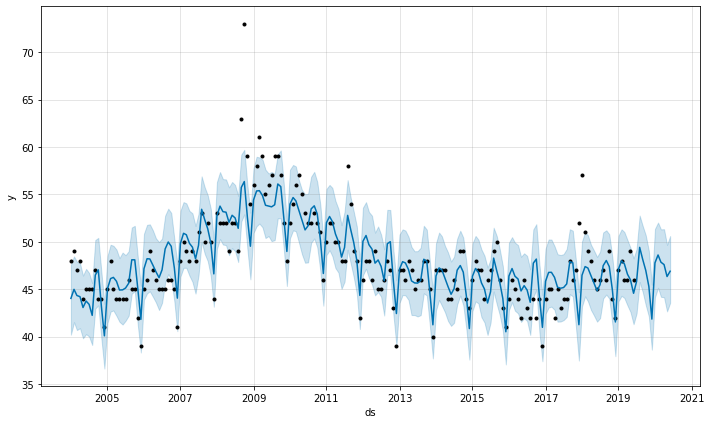

In [69]:
fig = modelProphetTrain_finance.plot(forecast_finance)


También se realizará la descomposición en tendencia y estacionalidad para la serie de datos

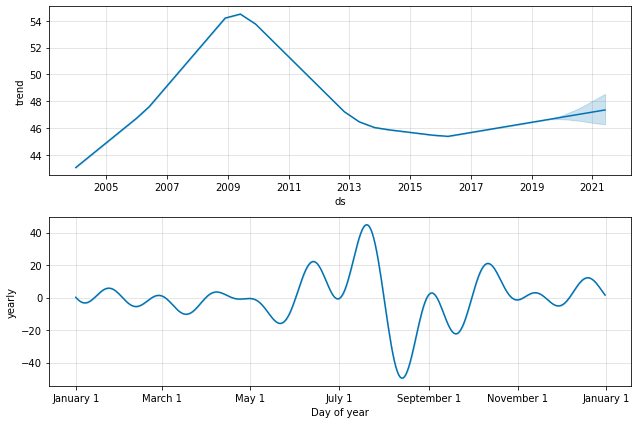

In [73]:
fig_compon_finance = modelProphetTrain_finance.plot_components(forecast_finance)

Durante la mayor parte del año el año la cantidad de busquedas presentan cierta estabilidad. Sin embargo, se observa un incremento destacado en el número de busquedas entre julio y agosto seguida de una caída entre agosto y septiembre que termina con la estabilziación de la serie en valores cercanos al promedio.  Por otro lado, en los meses de junio y octubre también se presentan unas subidas aunque estas son mucho más leves que la presentada enntre Julio y Agosto.

Desde el año 2004 se observa un aumento del interés por las busquedas en finanzas, este interés alcanzó su pico en el año 2009, seguido de un descenso en las busquedas entre el año 2009 y 2013 en donde se estabilizaron las busquedas aunque desde el 2019 se observa una ligera tendencia creciente.

La crisis financiera del año 2008 y 2009 coincide con el mayor interés en finanzas.

# Pronostico para la serie "gym"


In [75]:
future_gym = modelProphetTrain_gym.make_future_dataframe(periods=24, freq='MS')
forecast_gym = modelProphetTrain_gym.predict(future_gym)
forecast_gym.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
205,2021-02-01,56.188451,56.292602,60.187209,55.759133,56.660967,2.003313,2.003313,2.003313,2.003313,2.003313,2.003313,0.0,0.0,0.0,58.191764
206,2021-03-01,56.331443,54.730060,58.791002,55.879298,56.837644,0.409519,0.409519,0.409519,0.409519,0.409519,0.409519,0.0,0.0,0.0,56.740962
207,2021-04-01,56.489756,53.311680,57.484604,56.000585,57.042208,-1.162706,-1.162706,-1.162706,-1.162706,-1.162706,-1.162706,0.0,0.0,0.0,55.327050
208,2021-05-01,56.642962,52.737102,56.738971,56.112350,57.231322,-1.872804,-1.872804,-1.872804,-1.872804,-1.872804,-1.872804,0.0,0.0,0.0,54.770158
209,2021-06-01,56.801274,53.413053,57.602409,56.227903,57.425071,-1.288037,-1.288037,-1.288037,-1.288037,-1.288037,-1.288037,0.0,0.0,0.0,55.513237


Similarmente, para la serie "gym" se presenta el pronostico a un año y el ajuste de la serie temporal con el modelo ganador (modelo aditivio ajustado con el módulo prophet), se observa que el modelo captura adecuadamente la dinámica de la serie temporal, se observa una fuerte tendencia al alza en el interés por temas de gimnasio. También es muy notorio el alto interés por los gimnnasios a comienzo de año con una fuerte caída seguido con un repunte a mitad de año de los gimnaisos para nuevamente presentar una nueva caida de interés por los ginmanios.

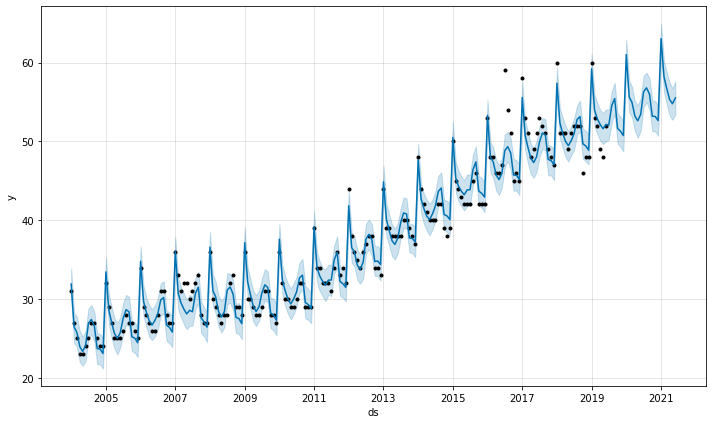

In [76]:
fig = modelProphetTrain_gym.plot(forecast_gym)


Detallaremos lo anterior en la descomposición de la serie temporal:

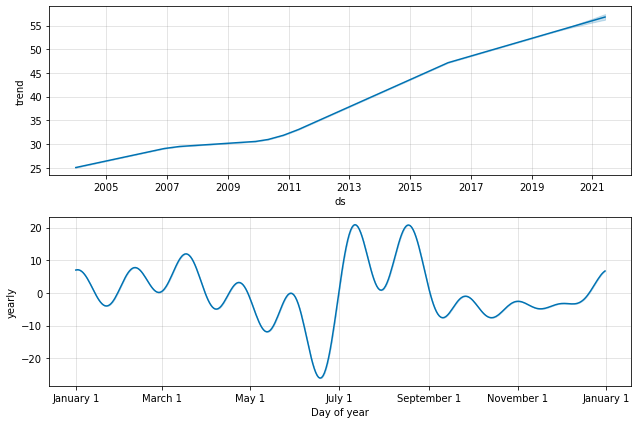

In [83]:
fig_compon_gym= modelProphetTrain_gym.plot_components(forecast_gym)

Se confirma en la descomposición que se ha venido presentado un fuerte ascenso en el interés por los gimnasios especialmente desde el año 2011. También se observan ascensos pronunciados a principio y a final de año.

## Diet

Para la serie de dieta aunque el modelo ganador es el ARIMA se explora el pronostico con el modelo aditivo y se analiza la descomposición de la serie para finalmente realizar el pronostico por el modelo SARIMA:

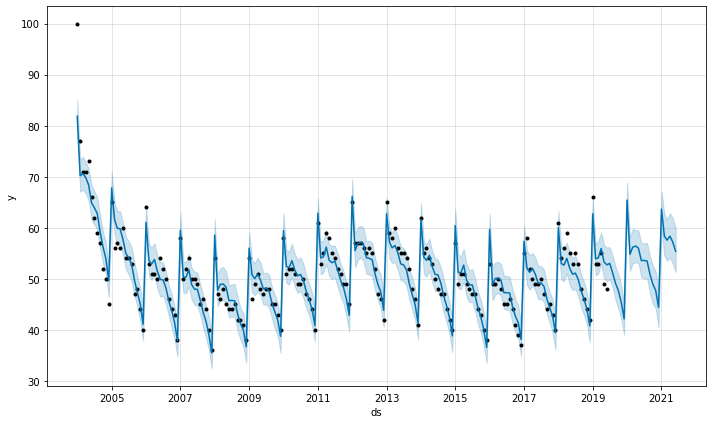

In [80]:
future_diet = modelProphetTrain_diet.make_future_dataframe(periods=24, freq='MS')
forecast_diet = modelProphetTrain_diet.predict(future_diet)
fig = modelProphetTrain_diet.plot(forecast_diet)

La serie de busquedas de dieta presento un  decrecimiento entre el 2004 y 2005 para estabilizarse de ahí en adelante. Es muy notorio el interés por las dietas a principio de año, lo anterior lo confirmaremos con la descomposición de la serie:

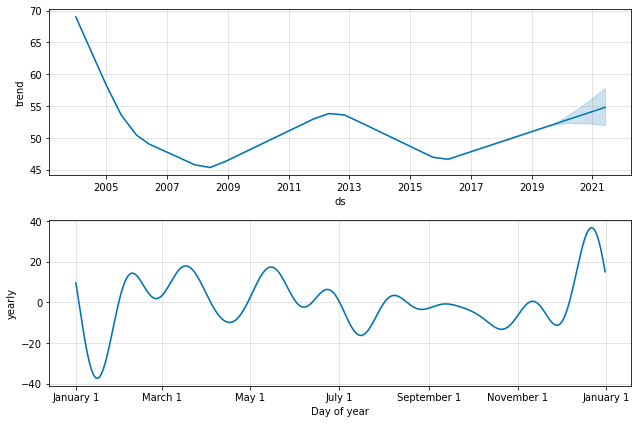

In [178]:
fig_compon_diet= modelProphetTrain_diet.plot_components(forecast_diet)

En efecto se confirma el fuerte incremento de todos los eneros y se logra detectar un descenco del interés por las dietas entre el 2004 y el 2008 para podsteriormente presentarse un aumento de interés por las dietas entre el 2008 y el 2012 para presentarse una nueva caída dhasta el año 2016. Desde ese año el interés por las dietas ha presentado interés pero sin retomar el interés cque existía antes del año 2005 las dietas.

Se hará uso del modelo ganador para realizar los pronosticos:    
    

In [92]:
future_diet

,ds
0,2004-01-01
1,2004-02-01
2,2004-03-01
3,2004-04-01
4,2004-05-01
...,...
205,2021-02-01
206,2021-03-01
207,2021-04-01
208,2021-05-01


El pronostico mediante el modelo SARIMA se presenta en la siguiente tabla:

In [168]:
df_missing = pd.DataFrame(np.repeat(np.nan, [12], axis=0), columns = ['y'])
df_y_diet = pd.Series.to_frame(pd.concat([df_diet.y, df_missing.y], axis = 0))
df_y_diet=df_y_diet.reset_index()
df_pron_diet = pd.DataFrame(pd.Series(y_predArima_diet))
df_pron_diet.columns=['y_pred']
y_predArima_diet = modelSArimaTrain_diet.predict(n_periods=210)
df_predArima_diet = pd.DataFrame({'date':future_diet.ds,  'y':df_y_diet.y, 'y_hat':df_pron_diet.y_pred})
df_predArima_diet

,date,y,y_hat
0,2004-01-01,100.0,48.638396
1,2004-02-01,77.0,47.371262
2,2004-03-01,71.0,44.179380
3,2004-04-01,71.0,42.411252
4,2004-05-01,73.0,40.527394
...,...,...,...
205,2021-02-01,NaN,41.303320
206,2021-03-01,NaN,38.758506
207,2021-04-01,NaN,37.168644
208,2021-05-01,NaN,35.441019


In [ ]:
Se observa que a futuro la tendencia se mantiene:

C:\ProgramData\Anaconda3\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 12 rows containing missing values.


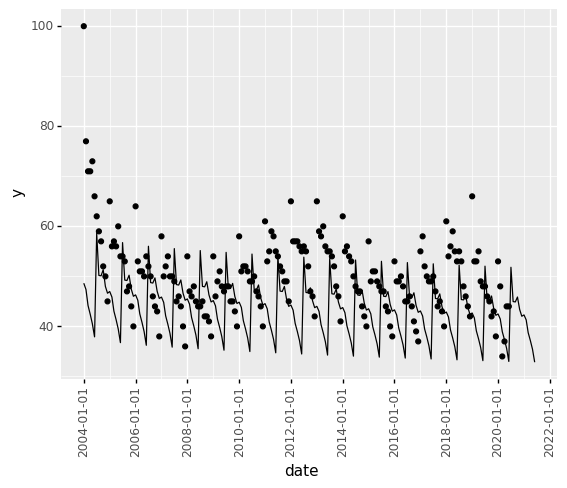

<ggplot: (94038954120)>

In [176]:
(ggplot(df_predArima_diet, aes(x = 'date', y = 'y'))
+ geom_point() 
+ geom_line(aes(x = 'date', y = 'y_hat'))) + theme(axis_text_x=element_text(angle=90))

# CONCLUSIONES

La serie "diet" presenta un comportamiento fuertemente estacional, presenta picos a principio de año seguido de un fuerte descenso en febrero y una relativa estabilización de la serie dureante el año. Hubo furor del tema en los años 2004 y 2005 para luego decrecer el interés y mantenerse relativamente constante. las busquedas asociadas a "gym" en contraste han presentando un interés creciente y también presenta un comportamiento pronunciado a principio y a mediados de año. Ambas series reflejan el interés de las personas por realizar propositos para tener habitos saludables a comienzo de año.
Finalmente la serie de finanzas es mucho irregular, presenta un comportamiento relativamente constante y presenta una estacionalidad moderada.